# Decision Tree Classification
Derek Gloudemans

Machine Learning Assignment 1

## Description of Decision Tree Implementation
For this assignment, decision trees were implemented as the class TreeNode. This object contains a subset of the training data and examples, as well as a recursive list of child TreeNodes. This class also implemented functions for:
- Obtaining the gini and entropy impurity for a split
- Obtaining the optimal split
- Fitting the tree to the training data
- Returning information about the tree such as depth and number of nodes
- Finding and pruning the optimal node based on validation dataset accuracy
- Plotting the tree

The full implementation, along with explanatory comments, can be found in the file TreeNode.py. A few of the most important functions are described here.

### TreeNode.compute_optimal_split()
This function iterates through all features, and every value in the training dataset for each feature. Each unique combination of feature and value is considered as a potential split. The split that has the lowest resulting impurity is selected. Impurity is calculated using the tree's impurity function, which is defined when the tree is initialized. compute_optimal_split also returns the indices of nodes in the left and right partition after the split, which makes it easy to divide the dataset for fitting the tree.

In [1]:
 def compute_optimal_split(self):
        """
        Finds optimal split for all data at node
        returns:
            j_opt - integer -  optimal feature to split on
            t_popt - float - optimal threshold to split on
            val - float - impurity value of optimal split
            left - list - indices of left partition
            right - list - indices of right partition
        """
        x = self.X
        
        # store current best values
        j_opt = 0
        t_opt = -np.inf
        best_val = np.inf 
        
        # consider each feature
        for j in range(len(x[0])): 
            # consider each value as the threshold value
            for i in range(len(x)):
                
                # get impurity val
                val = self.criterion(j,x[i,j])[0]
                
                if val < best_val:
                        # update current best values
                        best_val = val
                        j_opt = j
                        t_opt = x[i,j]
        # obtain final best partition and best value                
        val,[left,right] = self.criterion(j_opt,t_opt)
        
        return j_opt,t_opt, best_val, [left,right]

### TreeNode.fit()
This function recursively defines the tree structure and fits it to data by adding new nodes according to the computed optimal split. As long as the data at a node can still be further partitioned, fit() creates two new nodes according to this partition, each containing the corresponding subsets of the data from the current node. Each of these nodes is then recursively fit() in the same manner until no further improvements can be made to the classifier.

In [2]:
def fit(self,depth_limit = 1000):
        """
        Recursively creates a decision tree in a depth-first manner 
        by computing the optimal split of each node until
        nodes are pure, features are identical, or depth limit is reached
        depth_limit - int >= 0 - specifies maximum depth of tree
        """
        
        # compute optimal split on data if there is still class impurity
        if self.depth < depth_limit and self.impurity > 0.001:
            j,t,val,[left,right] = self.compute_optimal_split()
            self.split = (j,t)
            
            # tree is still able to be further subdivided since both partition lists have some elements
            if len(left) > 0 and len(right) > 0:
                
                #create two new nodes on partitions of data and add to self.children
                left_node = TreeNode(self.X[left,:],self.Y[left],depth = self.depth + 1, criterion = self.criterion_name ) 
                right_node = TreeNode(self.X[right,:],self.Y[right],depth = self.depth + 1, criterion = self.criterion_name ) 
                
                # recursively fit each child node
                left_node.fit(depth_limit)
                right_node.fit(depth_limit)
                
                # assign these nodes as children of the current node
                self.children = [left_node, right_node]

### TreeNode.predict()
This function calls the function TreeNode._walk() for each example in a numpy array of examples. _walk() recursively travels down a tree starting at its root node. At each node, the examples value for the splitting feature j is compared against the threshold t and the example is passed to the appropriate child of the tree depending on the comparison. When the example reaches a leaf node, the majority label at that node is assigned to the example and returned.

In [3]:
def predict(self,X_new):
    """
    outputs predicted classes for each example in X_new
    X_new - m x n array of examples (m examples, n features)
    returns:
        Y_pred - m x 1 array of predicted labels
    """
    Y_pred = np.zeros(len(X_new))

    for i in range(0,len(X_new)):
        Y_pred[i] = self._walk(X_new[i])
    return Y_pred


def _walk(self,x):
    """
    gets predicted class for one example
    x - 1 x n array for one example
    returns:
        y_pred - int - predicted label
    """
    if self.children:
        # pass example to correct child node
        j = self.split[0]
        t = self.split[1]
        if x[j] <= t:
            return self.children[0]._walk(x)
        else:
            return self.children[1]._walk(x)
    else:
        # get most common label in node if node is a leaf node
        return np.bincount(self.Y).argmax()

### TreeNode.prune_single_node_greedy()
This function first obtains a list of the unique paths to every node in the tree. For example the path [0,1,0] indicates:
- start at root node (this is always done)
- travel to left child node (the first 0)
- travel to right child node (the 1)
- travel to left child node (the second 0)

This notation makes it simple to get to any node in the tree from the root node. For each path (corresponding to a node), a new tree is created by copying the original tree and deleting the children of the node corresponding to the path (and by extension, all of the descendant nodes). This interpretation was chosen because it doesn't make much sense to delete only one of the two child nodes for a given node.  The resulting accuracy was obtained for each deletion. After all nodes were considered for pruning, the deletion with the highest overall accuracy (as evaluated using a validation dataset) is selected. The resulting pruned tree and the validatio accuracy are returned.

In [4]:
def prune_single_node_greedy(self,X_val,Y_val):
    """
    Removes all of a node's children and descendant nodes, condensing all examples into that node
    Node is selected greedily according to classification accuracy on validation
    data provided.
    """

    # get all paths to nodes
    paths = self.get_all_node_paths()
    best = None
    best_acc = 0

    # each path corresponds to one node in the tree
    for path in paths:
        pruned = copy.deepcopy(self)
        current_node = pruned
        while path != []:
            current_node = current_node.children[path.pop(0)]

        # remove children
        current_node.children = []

        # make predictions and get error
        acc,_ = pruned.predict_score(X_val,Y_val)
        if acc > best_acc:
            best_acc = acc
            best = copy.deepcopy(pruned)

    return best,best_acc

def get_all_node_paths(self,current_path = [], include_leaves = False):
    """ 
    recursively returns a list of lists, each list corresponding to the path through 
    children to reach a node that is not already a leaf node
    """
    all_node_paths = []

    # check for improper pruning of only one child node
    if len(self.children) == 1:
        raise Exception

    # if node has children, recursively call get_all_node _paths
    if self.children:
        path_left = current_path.copy()
        path_left.append(0)
        all_node_paths_left = self.children[0].get_all_node_paths(path_left,include_leaves = include_leaves)

        path_right = current_path.copy()
        path_right.append(1)
        all_node_paths_right = self.children[1].get_all_node_paths(path_right,include_leaves = include_leaves)

        all_node_paths = [current_path] + all_node_paths_left + all_node_paths_right

    # otherwise, return current path (only if include_leaves, since this is a leaf node)
    elif include_leaves:
        all_node_paths.append(current_path)

    return all_node_paths

## Code for Producing and Displaying Results

The following code snippets were used to generate classification accuracy results for each tree and dataset.

In [13]:
#--------------------------Import Packages------------------------------------#
import numpy as np
import copy
import csv
from TreeNode import TreeNode
import matplotlib.pyplot as plt

In [6]:
#-----------------------Function Definitions----------------------------------#

def load_cancer_CSV(file_name):
    """
    loads data from CSV (where first column in class label) into an X and Y 
    np array
    file_name - string - name of data csv.
    returns:
        X - m x n array of features for data examples
        Y - m x 1 array of labels for data examples
    """
    data = np.loadtxt(open(file_name, "rb"), delimiter=",", skiprows=1)
    Y = data[:,0].astype(int)
    X = data[:,1:]
    return X,Y

def classify_dataset(X_train,Y_train,X_test,Y_test,impurity = 'gini',dataset_id = 1):
    """
    condenses training and predicting code with a decision tree for cleanliness.
    """
    # fit a tree to each dataset
    tree = TreeNode(X_train,Y_train,criterion = impurity)
    tree.fit(depth_limit = 25)
    print("Decision tree classifier with {} impurity metric fit to data.".format(impurity))

    # score tree
    _,train_result = tree.predict_score(X_train,Y_train)
    _,test_result = tree.predict_score(X_test,Y_test)
    print("Results obtained for test dataset.\n")

    # get node counts
    non_leaf_count = tree.get_node_count(include_leaves = False)
    leaf_count = tree.get_node_count(include_leaves = True)

    # plot tree in new window (openCV required)
    if False:
        try:
            tree.plot(legend = ["Benign", "Malignant"])
        except NameError:
            print("OpenCV package required.")

    # print results in table
    print("------------------Results for Dataset {} -----------------".format(dataset_id))
    print("|  Metric       |  Training Dataset  |  Testing Dataset  |")
    print("|  Total Nodes  |                   {}                   |".format(leaf_count+non_leaf_count))
    print("|  Leaf Nodes   |                   {}                   |".format(non_leaf_count))
    print("|  Accuracy     |  {:.03f}             |  {:.03f}            |".format(train_result['acc'],test_result['acc']))
    print("---------------------------------------------------------\n")

## Dataset 1 Classification

In [7]:
# load dataset
X_train1,Y_train1 = load_cancer_CSV("cancer_datasets_v2/training_1.csv")
X_val1,Y_val1 = load_cancer_CSV("cancer_datasets_v2/validation_1.csv")
X_test1,Y_test1 = load_cancer_CSV("cancer_datasets_v2/testing_1.csv")
print("Dataset 1 loaded.")

# use gini impurity
classify_dataset(X_train1, Y_train1,X_test1,Y_test1,impurity = 'gini', dataset_id = 1)



Dataset 1 loaded.
Decision tree classifier with gini impurity metric fit to data.
Results obtained for test dataset.

------------------Results for Dataset 1 -----------------
|  Metric       |  Training Dataset  |  Testing Dataset  |
|  Total Nodes  |                   58                   |
|  Leaf Nodes   |                   19                   |
|  Accuracy     |  0.992             |  0.895            |
---------------------------------------------------------



### Decision Tree for Dataset 1 with Gini Impurity Metric
This and subsequent decision plots should be identical to those produced by the TreeNode.plot() function. They are included as .jpg files in case the user does not have OpenCV installed, as this package is used for plotting these trees.
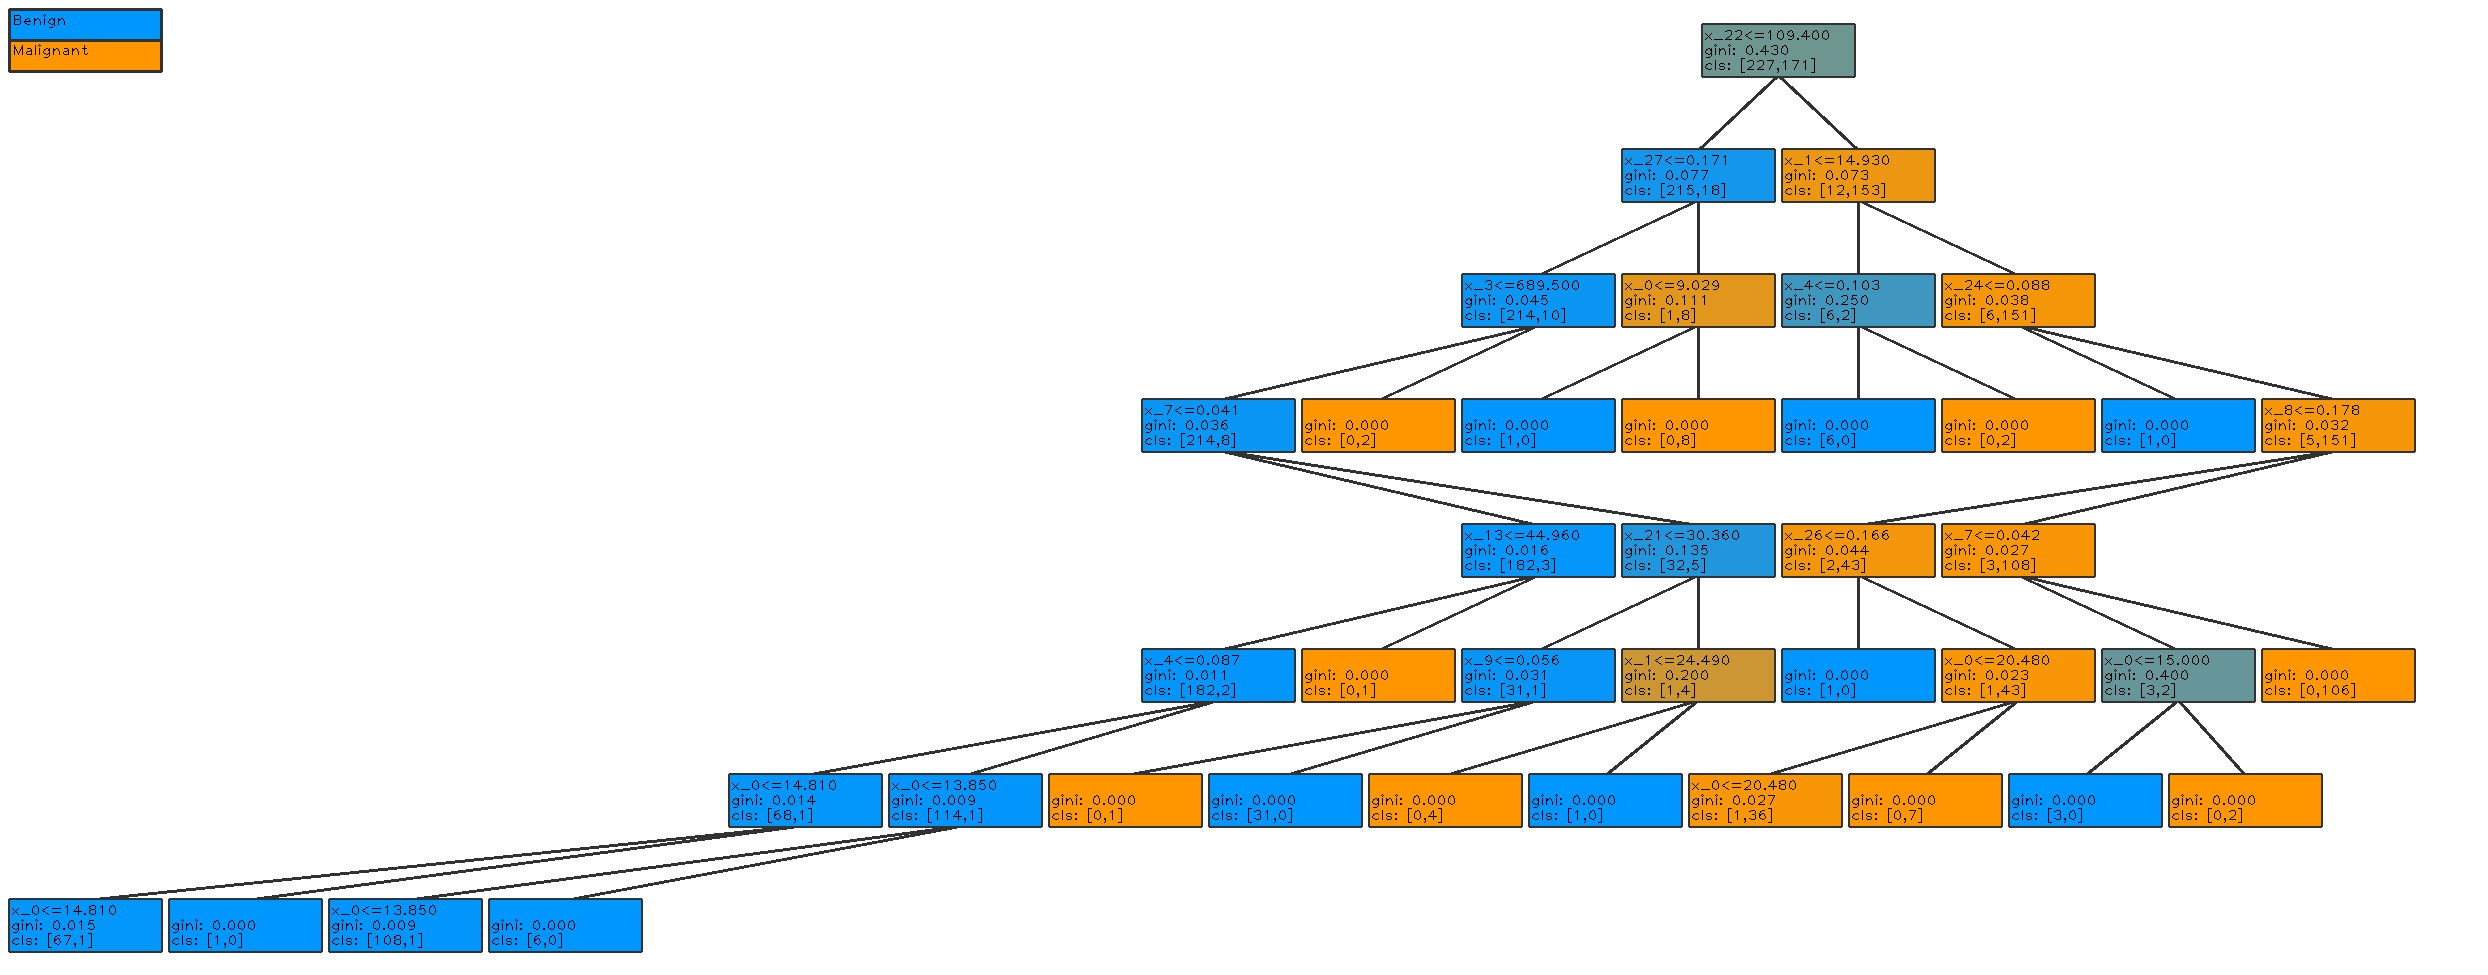

In [8]:
# use entropy impurity
classify_dataset(X_train1, Y_train1,X_test1,Y_test1,impurity = 'entropy', dataset_id = 1)

Decision tree classifier with entropy impurity metric fit to data.
Results obtained for test dataset.

------------------Results for Dataset 1 -----------------
|  Metric       |  Training Dataset  |  Testing Dataset  |
|  Total Nodes  |                   49                   |
|  Leaf Nodes   |                   16                   |
|  Accuracy     |  1.000             |  0.947            |
---------------------------------------------------------



### Decision Tree for Dataset 1 with Entropy Impurity Metric
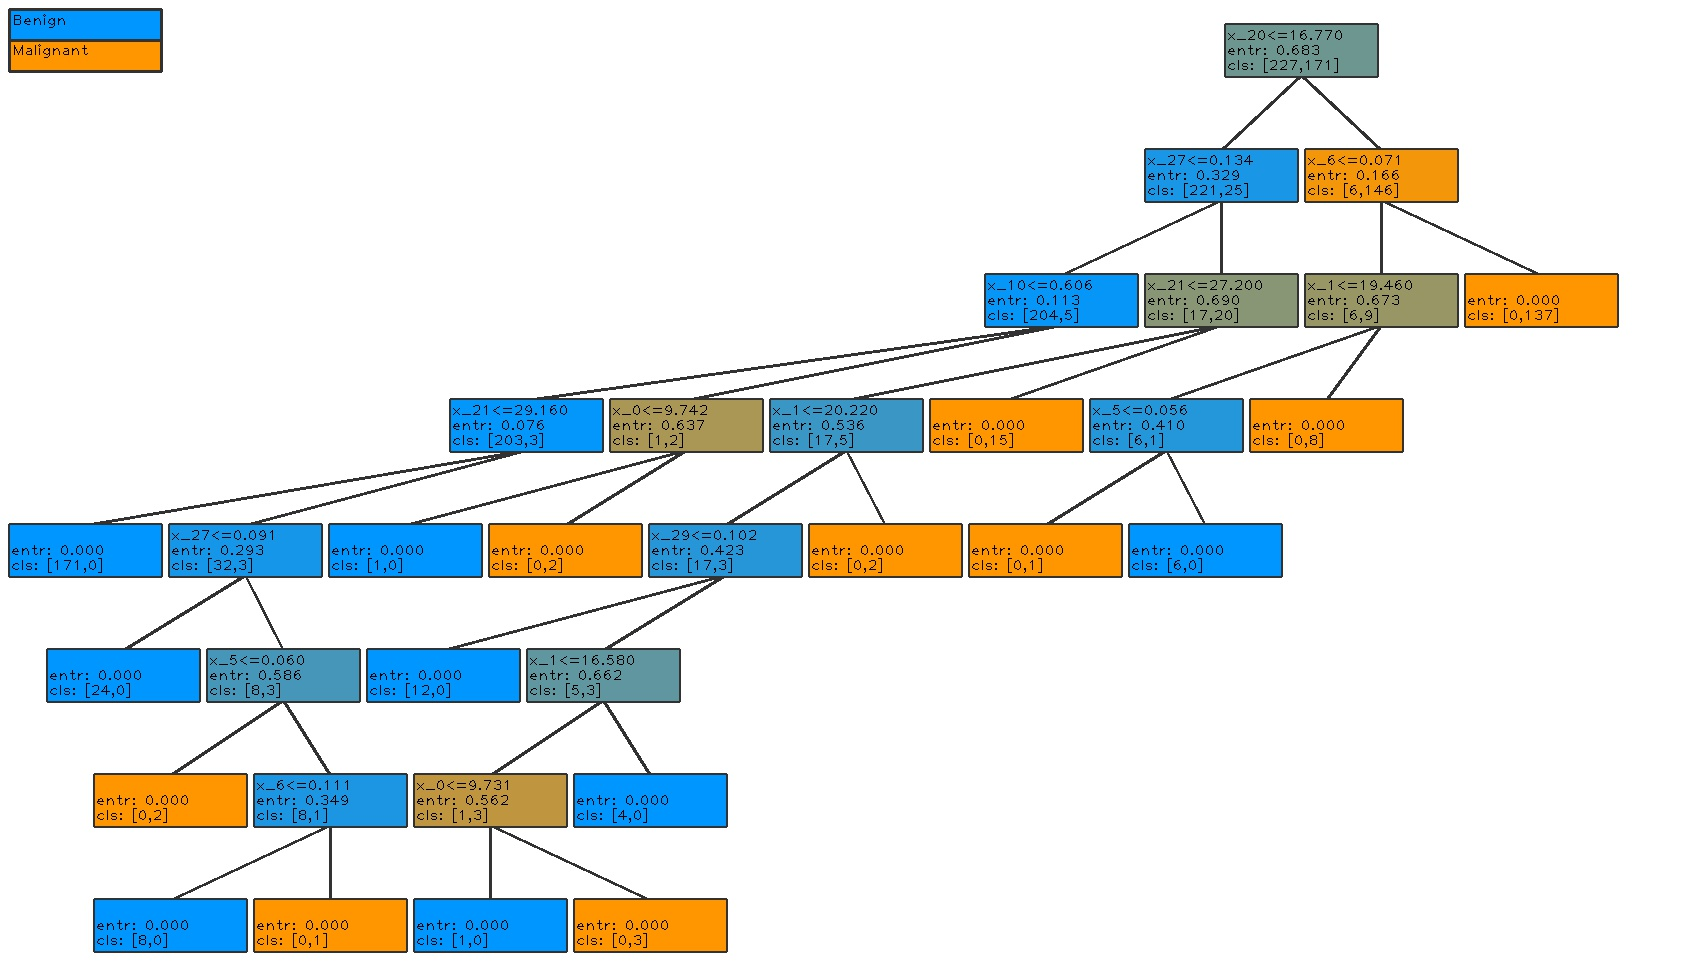

## Dataset 2 Classification


In [9]:
# load dataset
X_train2,Y_train2 = load_cancer_CSV("cancer_datasets_v2/training_2.csv")
X_val2,Y_val2 = load_cancer_CSV("cancer_datasets_v2/validation_2.csv")
X_test2,Y_test2 = load_cancer_CSV("cancer_datasets_v2/testing_2.csv")
print("Dataset 2 loaded.")

# use gini impurity
classify_dataset(X_train2, Y_train2,X_test2,Y_test2,impurity = 'gini', dataset_id = 2)

Dataset 2 loaded.
Decision tree classifier with gini impurity metric fit to data.
Results obtained for test dataset.

------------------Results for Dataset 2 -----------------
|  Metric       |  Training Dataset  |  Testing Dataset  |
|  Total Nodes  |                   58                   |
|  Leaf Nodes   |                   19                   |
|  Accuracy     |  0.993             |  0.877            |
---------------------------------------------------------



### Decision Tree for Dataset 2 with Gini Impurity Metric
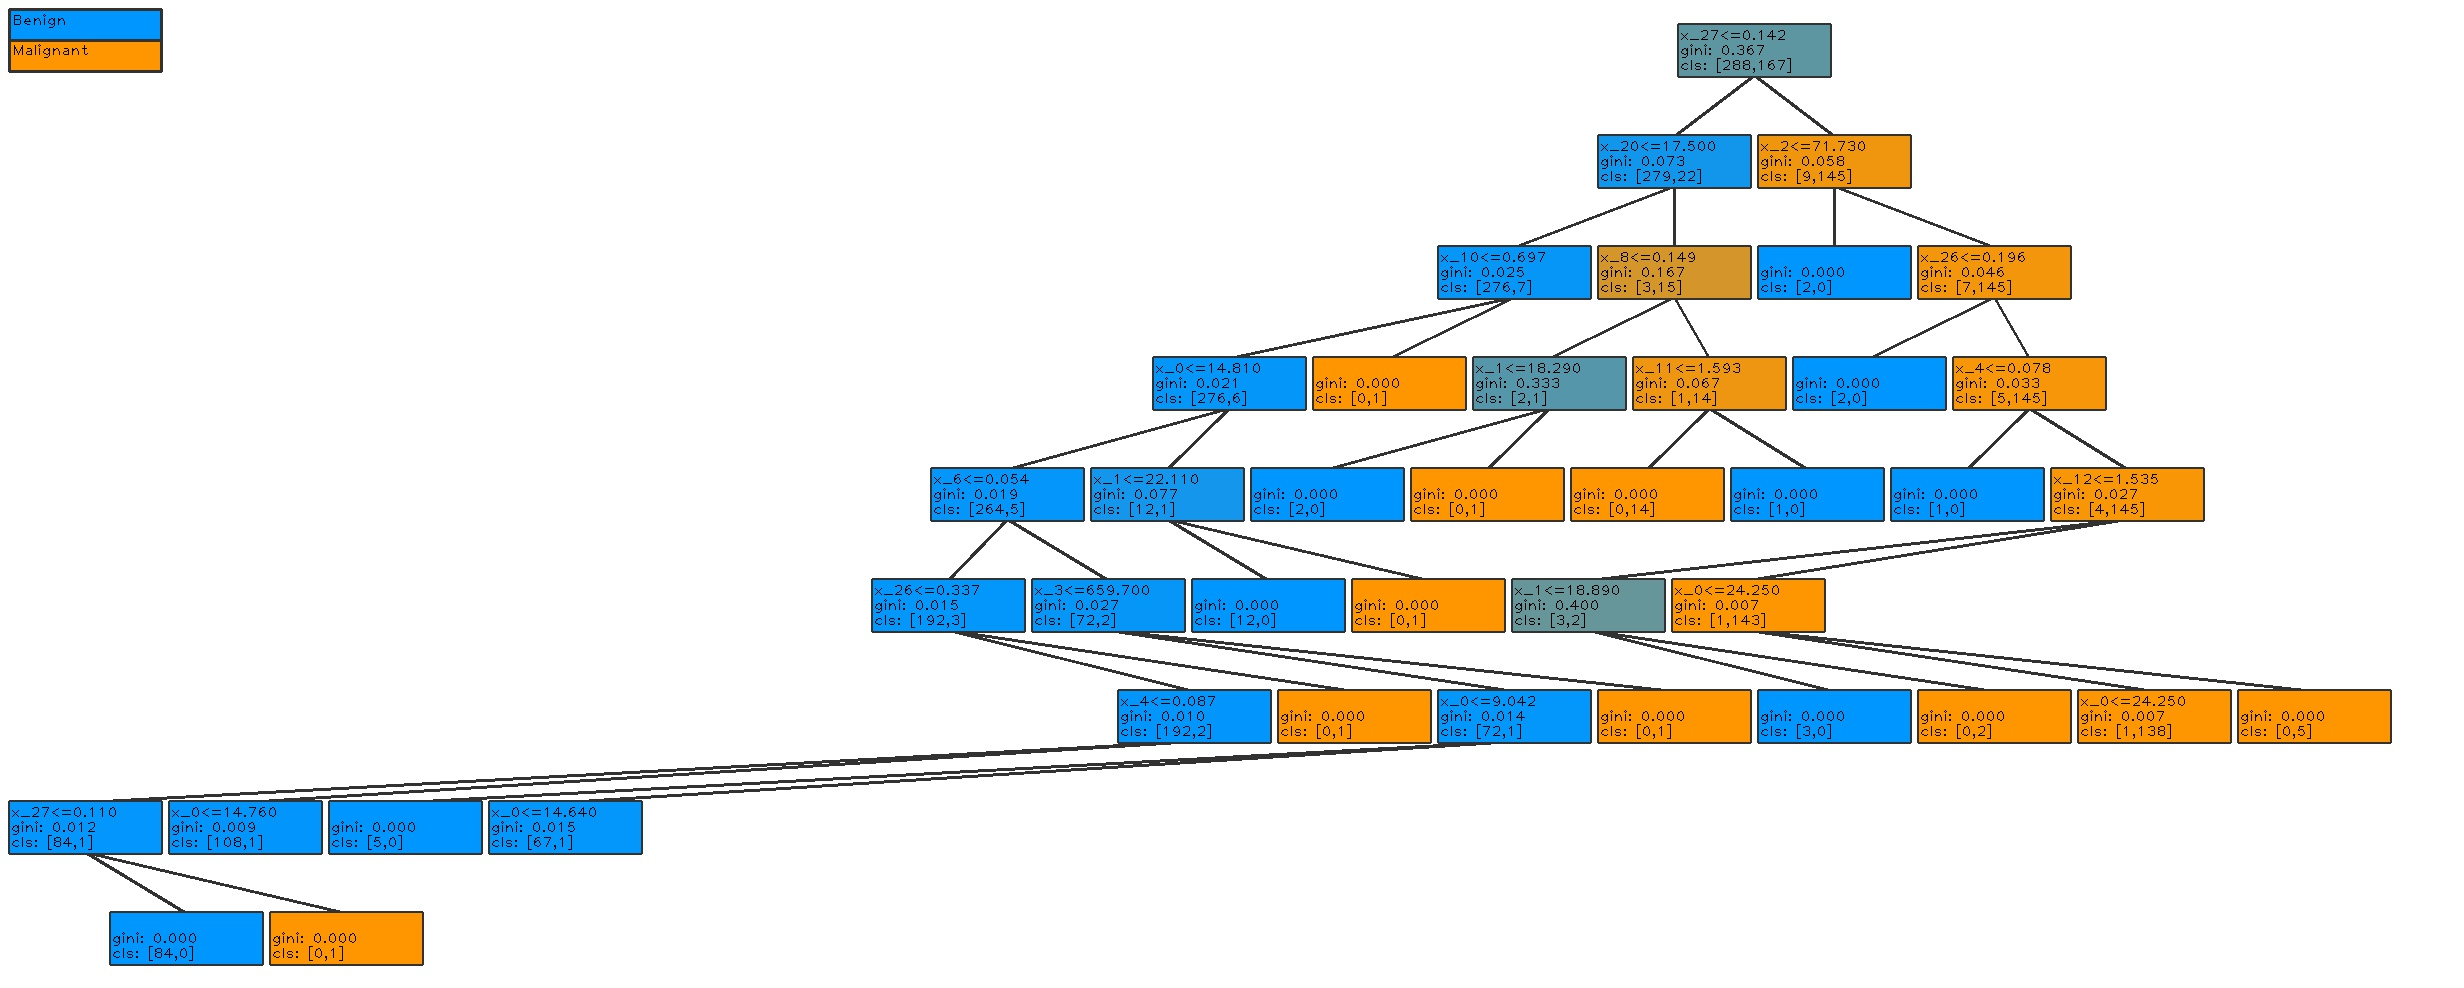

In [10]:
# use entropy impurity
classify_dataset(X_train2, Y_train2,X_test2,Y_test2,impurity = 'entropy', dataset_id = 2)

Decision tree classifier with entropy impurity metric fit to data.
Results obtained for test dataset.

------------------Results for Dataset 2 -----------------
|  Metric       |  Training Dataset  |  Testing Dataset  |
|  Total Nodes  |                   43                   |
|  Leaf Nodes   |                   14                   |
|  Accuracy     |  1.000             |  0.877            |
---------------------------------------------------------



### Decision Tree for Dataset 2 with Entropy Impurity Metric
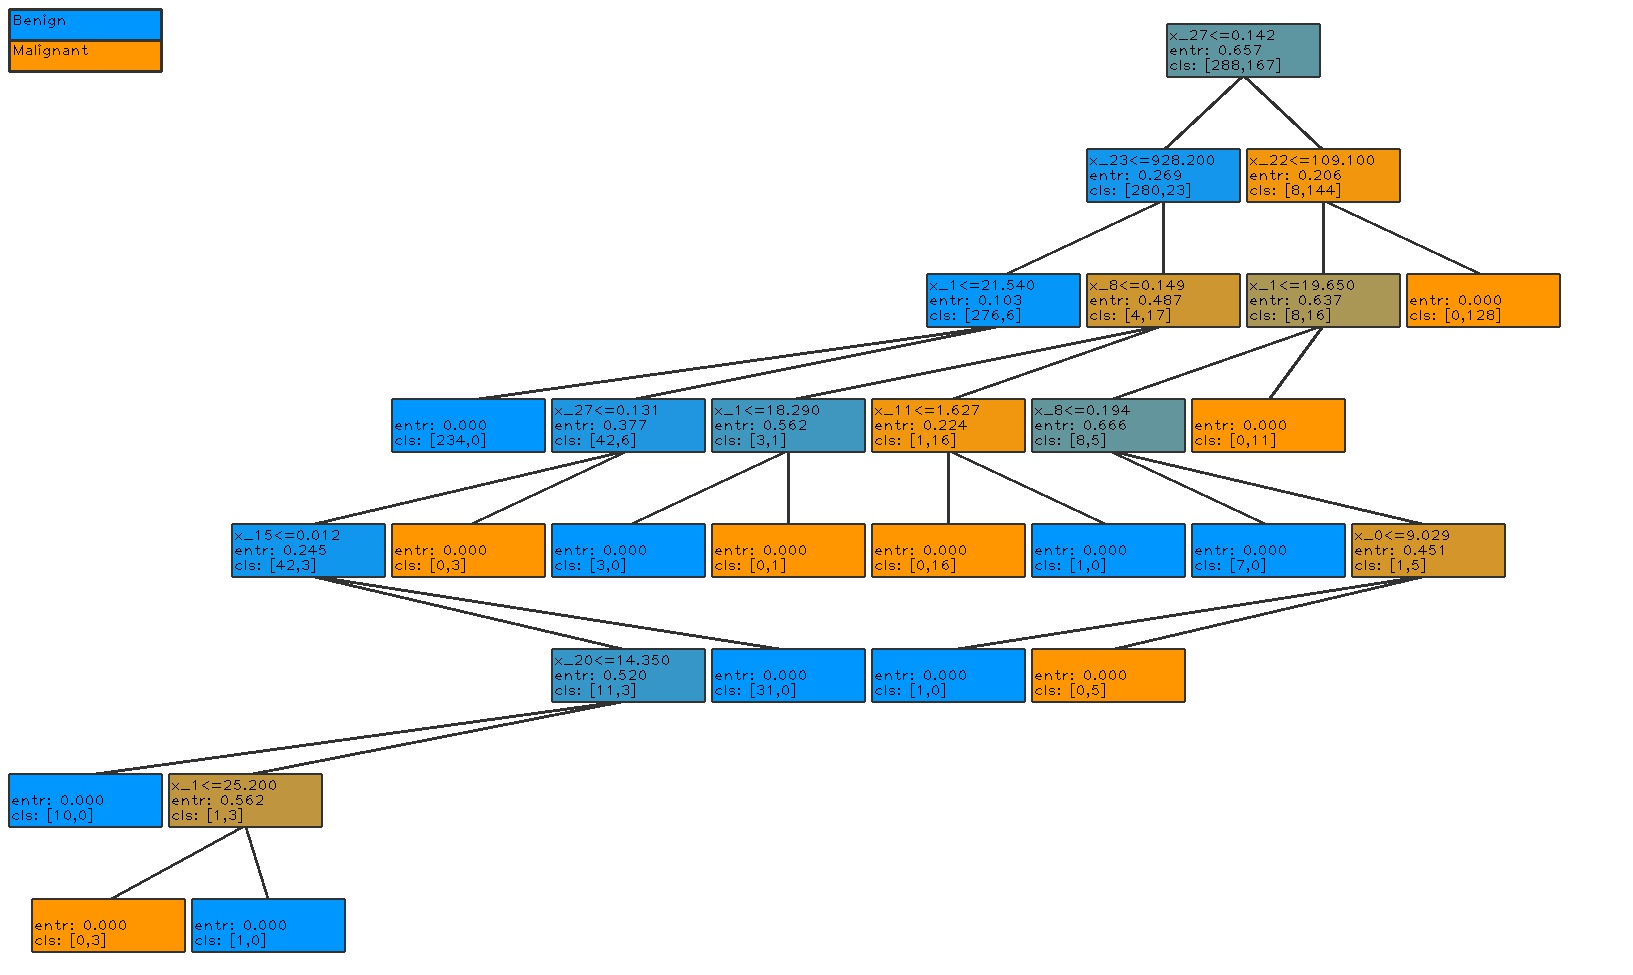

## Discussion of Results

A few observations of note can be made from these results:

- First of all, the unpruned trees continue to branch until no further class separation can be accomplished. In a few cases, the resulting leaf node is not entirely pure (i.e. at least one example from each class is grouped into that node). This occurred only in the tree trained using Gini impurity. Interestingly, in these cases, there are splits that would subdivide this data more, but no single split results in an increase in Gini impurity. This is because while the classification error for one node decreases, the error for the other node increases (because there is a greater fraction of examples that do not belong to the majority class in this node). Thus, the overall Gini impurity cannot decrease in this single step. Entropy impurity is not subject to this same shortcoming because it is not a function of the majority class but rather of all classes, weighted by their frequency. In this sense, Gini impurity is a sort of discretization of entropy impurity.  

- Secondly, trees created using entropy impurity are both smaller on average and more accurate (on dataset 1). In this case, entropy impurity seems to be a better means by which to split the tree, though this is not necessarily true for all datasets.

- Lastly, the performance of both decision trees is worse on dataset 2, of which a greater proportion was used for training rather than testing. This could perhaps be because the classifiers exhibit a greater degree of overfitting when trained on a larger proportion of the data and do not generalize as well to the test data. Interestingly, the entropy-based decision tree has fewer nodes (is less complex) for dataset 2, which does not support the claim that it is overfit to the training dataset. Perhaps the specific partition of the data is simply more difficult to classify with a decision tree classifier and this results in lower classificatio accuracy.However, it is difficult to make a claim either way based only on this single piece of evidence. K-fold cross validation would lend more credence to either claim. 

## Code for Pruning and Producing Results

The following code snippets were used to prune and record metrics for each tree. Note that the first value returned by TreeNode.predict_score() is accuracy and the second is a dictionary containing the following metrics:
- false positives
- true positives
- false negatives
- true negatives
- accuracy
- precision
- recall
- f1 score
- true positive rate
- false positive rate


In [11]:
def iterative_prune(X_train,X_val,X_test,Y_train,Y_val,Y_test,impurity = "gini"):
    """
    Removes one node from the tree optimally according to TreeNode.prune_single_node_greedy(),
    records metrics, and then repeats until only the root node remains.
    """
    tree = TreeNode(X_train,Y_train,criterion = impurity)
    tree.fit(depth_limit = 25)
    
    # for storing results
    results_list = []
    num_nodes = tree.get_node_count()
    
    while num_nodes > 0:
        # get results for all data
        _,train_result = tree.predict_score(X_train,Y_train)
        _,validation_result = tree.predict_score(X_val,Y_val)
        _,test_result = tree.predict_score(X_test,Y_test)

        # store results
        results_list.append([num_nodes,train_result,validation_result,test_result])

        # prune a node from the tree
        tree,_ = tree.prune_single_node_greedy(X_val,Y_val)
        
        # check whether the tree has any nodes left
        try:
            num_nodes = tree.get_node_count()
        except:
            break
    return results_list
            
def condense_results_list(results_list):
    """
    Condenses list of list of dictionaries into 3 numpy arrays of results
    where one row corresponds to:
        num_nodes, acc, f1, precision, recall, tpr, fpr
    for one tree in the pruning process
    """
    # condense data into an array for train, test and val
    # num_nodes, acc, f1, precision, recall, tpr, fpr
    train_res = np.zeros([len(results_list),7])
    val_res = np.zeros([len(results_list),7])
    test_res = np.zeros([len(results_list),7])
    
    for i,res in enumerate(results_list):
        train_res[i,0] = res[0]
        val_res[i,0] = res[0]
        test_res[i,0] = res[0]
        
        train_res[i,1] = res[1]['acc']
        val_res[i,1] = res[2]['acc']
        test_res[i,1] = res[3]['acc']
        
        train_res[i,2] = res[1]['f1']
        val_res[i,2] = res[2]['f1']
        test_res[i,2] = res[3]['f1']
        
        train_res[i,3] = res[3]['precision']
        val_res[i,3] = res[3]['precision']
        test_res[i,3] = res[3]['precision']
        
        train_res[i,4] = res[1]['recall']
        val_res[i,4] = res[2]['recall']
        test_res[i,4] = res[3]['recall']
        
        train_res[i,5] = res[1]['tpr']
        val_res[i,5] = res[2]['tpr']
        test_res[i,5] = res[3]['tpr']
        
        train_res[i,6] = res[3]['fpr']
        val_res[i,6] = res[3]['fpr']
        test_res[i,6] = res[3]['fpr']
        
    return train_res,val_res,test_res

def plot_prune_results(results_list, dataset_id = 1,impurity = "gini"):
    """
    Generates three plots for a tree pruning test:
        - Accuracy and F1 versus number of nodes (train, val, and test)
        - Precision recall curve (train, val, and test)
        - Receiver operating characteristic curve (train, val and test)
    """
    
    # condense results
    train_res,val_res,test_res = condense_results_list(results_list)
    
    # generate figure
    with plt.style.context('ggplot'):
        color1 = (129/255, 161/255, 214/255)
        color2 = (207/255, 137/255, 105/255)
        color3 = (173/255, 136/255, 179/255)
        fig, axarr = plt.subplots(1, 3, figsize = (20,5))
        fig.suptitle("Results for {} impurity decision tree on dataset {}".format(impurity,dataset_id),fontsize = 18)
        plt.subplots_adjust(left=None, bottom=None, right=None, top= None, wspace=0.25)
        
        # subplot 1 - accuracy versus number of nodes
        axarr[0].plot(train_res[:,0],train_res[:,1],'-',color = color1)
        axarr[0].plot(train_res[:,0],train_res[:,2],'--',color = color1)
        axarr[0].plot(val_res[:,0],val_res[:,1],'-',color = color2)
        axarr[0].plot(val_res[:,0],val_res[:,2],'--',color = color2)
        axarr[0].plot(test_res[:,0],test_res[:,1],'-',color = color3)
        axarr[0].plot(test_res[:,0],test_res[:,2],'--',color = color3)
        
        axarr[0].set_xlim([0, max(train_res[:,0])])
        axarr[0].set_ylim([0.5, 1])
        axarr[0].set_ylabel('Metric',fontsize = 14)
        axarr[0].set_xlabel('Number of nodes',fontsize = 14)
        axarr[0].set_title('Performance vs. number of nodes',fontsize = 16)
        legend = ["train acc.","train f1", "val. acc.", "val. f1.", "test acc.", "test f1"]
        axarr[0].legend(legend)

    
        # subplot 2 - precision versus recall
        axarr[1].plot(train_res[:,4],train_res[:,3],'-',color = color1)
        axarr[1].plot(val_res[:,4],val_res[:,3],'-',color = color2)
        axarr[1].plot(test_res[:,4],test_res[:,3],'-',color = color3)
        
        axarr[1].set_xlim([0, 1])
        axarr[1].set_ylim([0, 1])
        axarr[1].set_ylabel('Precision',fontsize = 14)
        axarr[1].set_xlabel('Recall',fontsize = 14)
        axarr[1].set_title('Precision vs. recall',fontsize = 16)
        legend = ["train PR.", "val PR", "test PR"]
        axarr[1].legend(legend)
        
        # subplot 3 - ROC curve
        axarr[2].plot(train_res[:,6],train_res[:,5],'-',color = color1)
        axarr[2].plot(val_res[:,6],val_res[:,5],'-',color = color2)
        axarr[2].plot(test_res[:,6],test_res[:,5],'-',color = color3)
        
        axarr[2].set_xlim([0, 1])
        axarr[2].set_ylim([0, 1])
        axarr[2].set_ylabel('True positive rate',fontsize = 14)
        axarr[2].set_xlabel('False positive rate',fontsize = 14)
        axarr[2].set_title('ROC curve',fontsize = 16)
        legend = ["train ROC.", "val ROC", "test ROC"]
        axarr[2].legend(legend)

## Dataset 1 Pruning

The results of pruning for the gini decision tree on dataset 1 are poor. The optimal node first selected to prune is the root node, so the plotted curves have only two points and are not a good representation of the data. 

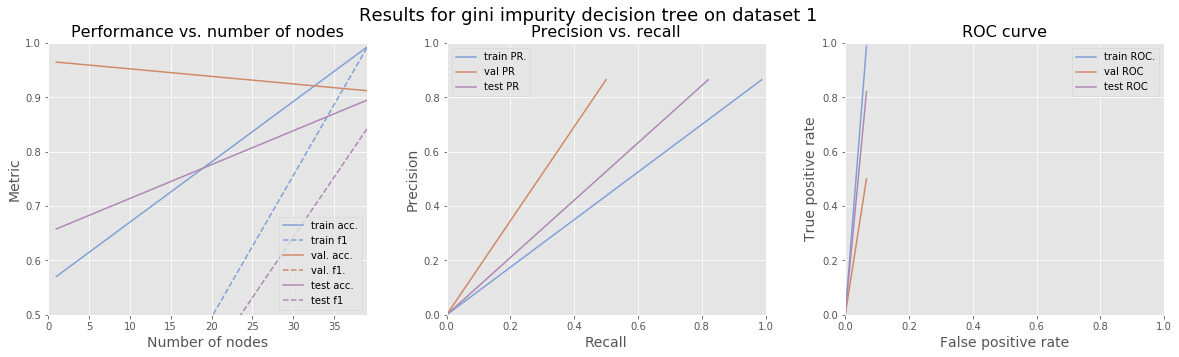

In [14]:
# get results for gini
results_list_gini_1 = iterative_prune(X_train1,X_val1,X_test1,Y_train1,Y_val1,Y_test1,impurity = 'gini')
plot_prune_results(results_list_gini_1,dataset_id = 1, impurity = "gini")

The results for the entropy impurity decision tree are closer to expected. Even so, the precision-recall and ROC curve are not very informative.

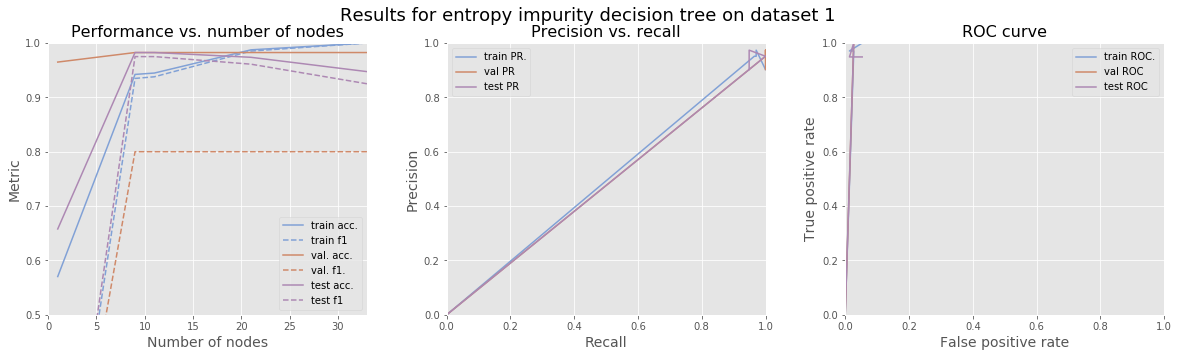

In [15]:
# get results for entropy
results_list_entropy_1 = iterative_prune(X_train1,X_val1,X_test1,Y_train1,Y_val1,Y_test1,impurity = 'entropy')
plot_prune_results(results_list_entropy_1,dataset_id = 1, impurity = "entropy")

example of tree pruning

## Dataset 2 Pruning

The results of pruning for the gini decision tree on dataset 2 are better than for dataset 1, suggesting something about the particular partition of data in dataset 1 was not well-suited for pruning. 

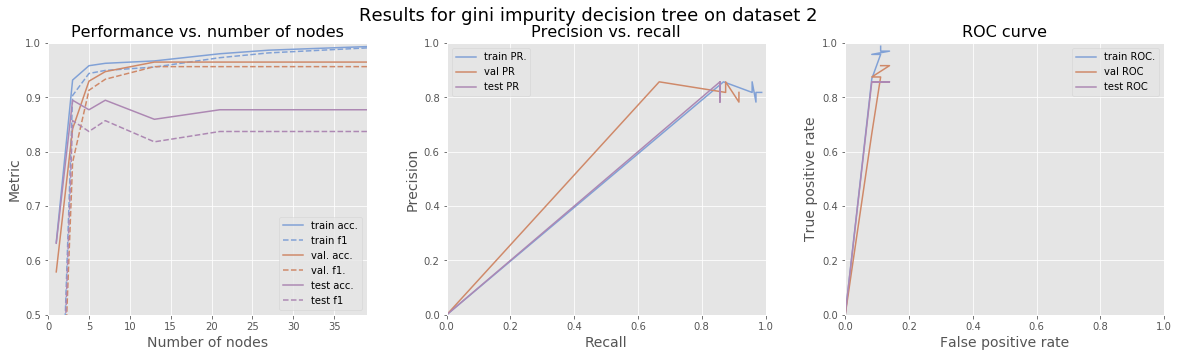

In [16]:
# get results for gini
results_list_gini_2 = iterative_prune(X_train2,X_val2,X_test2,Y_train2,Y_val2,Y_test2,impurity = 'gini')
plot_prune_results(results_list_gini_2,dataset_id = 2, impurity = "gini")

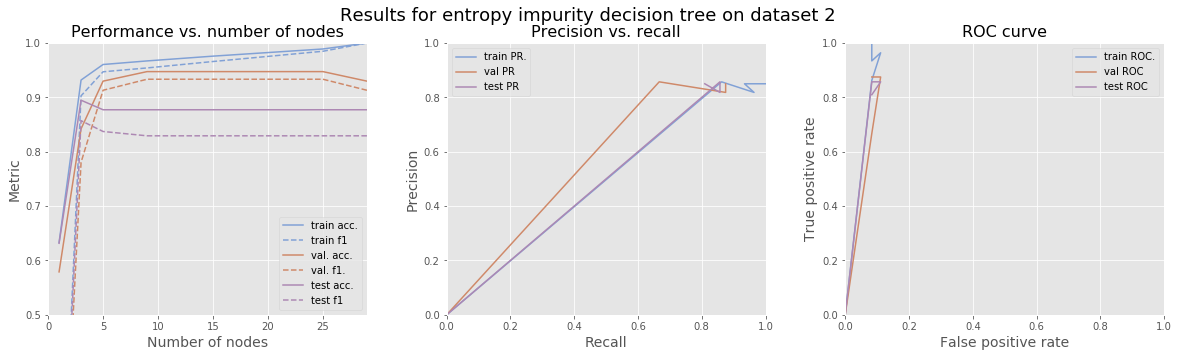

In [17]:
# get results for entropy
results_list_entropy_2 = iterative_prune(X_train2,X_val2,X_test2,Y_train2,Y_val2,Y_test2,impurity = 'entropy')
plot_prune_results(results_list_entropy_2,dataset_id = 2, impurity = "entropy")

An example of the iterative pruning process is shown below for the entropy impurity decision tree on dataset 2.

Original:
<img src="prune1.jpg"  width= 45%/>
Iteration 1:
<img src="prune2.jpg" width= 45%/>
Iteration 2:
<img src="prune3.jpg"  width= 45%/>
Iteration 3:
<img src="prune4.jpg" width= 45%/>
Iteration 4:
<img src="prune5.jpg"  width= 45%/>
Iteration 5:
<img src="prune6.jpg" width= 25%/>



## Discussion of Results

- Discuss F1 and accuracy
- Discuss any signs of overfitting (test and validation accuracy are lower)
- Discuss how PR curve and ROC curve scale roughly linearly
- Discuss why you wouldn't necessarily expect them to look like the curves shown in class (they are not explictly parametrized by the complexity of the tree).
- Best tree by each metric

